# Quantum Counting Algorithm

The Quantum Counting algorithm, introduced by Brassard, Høyer, and Tapp [1], counts the number of marked items $M$ in an unstructured database of $N = 2^n$ elements. It combines **Grover's search operator** with **Quantum Phase Estimation (QPE)** to achieve a quadratic speedup over classical counting, requiring only $O(\sqrt{N})$ oracle queries instead of the classical $\Theta(N)$.

**Key idea:** The Grover operator $G = D \cdot O$ has eigenvalues $e^{\pm i\theta}$, where $\theta$ satisfies $\sin^2(\theta/2) = M/N$. By applying QPE to $G$, we estimate $\theta$ and hence determine $M$.

## References

[[1] G. Brassard, P. Høyer, and A. Tapp, "Quantum Counting", Proceedings of ICALP 1998](https://arxiv.org/abs/quant-ph/9805082)

[[2] M. Nielsen and I. Chuang, Quantum Computation and Quantum Information, Cambridge University Press, 2010](https://www.cambridge.org/highereducation/books/quantum-computation-and-quantum-information/01E10196D0A682A6AEFFEA52D53BE9AE)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from braket.circuits import Circuit
from braket.devices import LocalSimulator
from braket.experimental.algorithms.quantum_counting import (
    build_grover_circuit,
    build_oracle_circuit,
    get_quantum_counting_results,
    quantum_counting_circuit,
)

%matplotlib inline

## Background

### The Grover Operator

Given an oracle $O$ that marks certain states by flipping their phase ($O|x\rangle = (-1)^{f(x)}|x\rangle$), and the Grover diffusion operator $D = 2|s\rangle\langle s| - I$, the Grover operator is:

$$G = D \cdot O$$

In the 2D subspace of marked ($|\beta\rangle$) and unmarked ($|\alpha\rangle$) states, $G$ acts as a rotation by angle $\theta$:

$$\sin^2(\theta/2) = M/N$$

### QPE on the Grover Operator

Within this 2-dimensional solution subspace, the eigenvalues of $G$ are $e^{\pm i\theta}$. QPE with $t$ precision (counting) qubits estimates the phase $\varphi = \theta/(2\pi)$ as a $t$-bit fraction $y/2^t$, where $y$ is the integer readout from the counting register. From our estimate of $\varphi$, we recover the number of marked items:

$$M = N \cdot \sin^2(\pi \varphi)$$

**Note:** The full $N \times N$ Grover matrix has additional eigenvalues from the orthogonal complement of the solution subspace, but these do not affect the counting algorithm since the initial uniform superposition $|s\rangle$ lies entirely within the 2D subspace.

## Build the Oracle and Grover Circuits

We build the oracle and Grover operator as **circuits** using primitives from the `grovers_search` module:
- `build_oracle` (from `grovers_search`) constructs a phase-flip oracle for a single basis state
- `amplify` (from `grovers_search`) constructs the diffusion operator $D = H \cdot O_0 \cdot H$
- `build_oracle_circuit` composes oracles for multiple marked states
- `build_grover_circuit` combines the oracle and diffusion into the full Grover operator $G$

In [2]:
# Search space: n_search = 2 qubits -> N = 4 elements
# Mark state |3> (binary '11')
n_search = 2
marked_states = [3]
N = 2**n_search

# Build the oracle circuit using primitives from grovers_search
oracle_circ = build_oracle_circuit(n_search, marked_states)
print("Oracle circuit (marks state |11>):")
print(oracle_circ)

# Build the full Grover operator circuit: G = Diffusion . Oracle
grover_circ = build_grover_circuit(n_search, marked_states)
print("\nGrover operator circuit (G = D . O):")
print(grover_circ)

Oracle circuit (marks state |11>):
T  : │  0  │  1  │  2  │  3  │  4  │
                                    
q0 : ───────────────●───────────────
                    │               
                    │               
q1 : ───────────────●───────────────
                    │               
      ┌───┐ ┌───┐ ┌─┴─┐ ┌───┐ ┌───┐ 
q2 : ─┤ X ├─┤ H ├─┤ X ├─┤ H ├─┤ X ├─
      └───┘ └───┘ └───┘ └───┘ └───┘ 
T  : │  0  │  1  │  2  │  3  │  4  │

Grover operator circuit (G = D . O):
T  : │  0  │  1  │  2  │  3  │  4  │  5  │  6  │  7  │  8  │  9  │
                        ┌───┐ ┌───┐                   ┌───┐ ┌───┐ 
q0 : ───────────────●───┤ H ├─┤ X ├───────────────●───┤ X ├─┤ H ├─
                    │   └───┘ └───┘               │   └───┘ └───┘ 
                    │   ┌───┐ ┌───┐               │   ┌───┐ ┌───┐ 
q1 : ───────────────●───┤ H ├─┤ X ├───────────────●───┤ X ├─┤ H ├─
                    │   └───┘ └───┘               │   └───┘ └───┘ 
      ┌───┐ ┌───┐ ┌─┴─┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌─┴

In [3]:
# Extract the Grover operator unitary from the circuit
grover_unitary = grover_circ.to_unitary()
print(f"Grover circuit unitary shape: {grover_unitary.shape}")
print(f"(Includes {grover_circ.qubit_count - n_search} ancilla qubit(s) from MCZ decomposition)")

# Eigenvalue analysis of the full circuit unitary
eigenvalues = np.linalg.eigvals(grover_unitary)
# Filter out trivial eigenvalues (1.0) to see the interesting ones
nontrivial = [ev for ev in eigenvalues if abs(ev - 1.0) > 0.01]
print(f"\nNon-trivial eigenvalues of G: {np.round(nontrivial, 4)}")

# In the 2D subspace spanned by |alpha> (unmarked) and |beta> (marked),
# the ideal Grover operator has eigenvalues e^{+/- i*theta}.
# However, the MCZ ancilla decomposition introduces a global phase of -1,
# so the circuit eigenvalues are -e^{+/- i*theta} = e^{+/- i*(theta + pi)}.
# This phase shift is corrected in get_quantum_counting_results.
theta = 2 * np.arcsin(np.sqrt(len(marked_states) / N))
print(f"\nGrover angle theta = {theta:.4f} rad")
print(f"Ideal eigenvalues in solution subspace:  "
      f"e^(+i*theta) = {np.exp(1j * theta):.4f},  "
      f"e^(-i*theta) = {np.exp(-1j * theta):.4f}")
print(f"Circuit eigenvalues (with -1 global phase): {np.round(nontrivial, 4)}")

Grover circuit unitary shape: (8, 8)
(Includes 1 ancilla qubit(s) from MCZ decomposition)

Non-trivial eigenvalues of G: [-0.5+0.866j -0.5-0.866j]

Grover angle theta = 1.0472 rad
Ideal eigenvalues in solution subspace:  e^(+i*theta) = 0.5000+0.8660j,  e^(-i*theta) = 0.5000-0.8660j
Circuit eigenvalues (with -1 global phase): [-0.5+0.866j -0.5-0.866j]


## Build the Quantum Counting Circuit

The quantum counting circuit consists of four key components:

1. **Initial state preparation**: Apply Hadamard gates to all counting qubits (QPE initialization) and all search qubits (prepare uniform superposition $|s\rangle$)
2. **Controlled Grover operators**: Apply controlled-$G^{2^k}$ for each counting qubit $k$ (QPE phase kickback)
3. **Inverse QFT**: Applied to the counting qubits to extract the phase estimate
4. **Measurement**: Probability distribution over the counting (QPE) register only

In [4]:
# Use 4 counting qubits (t = 4) for good precision
n_counting = 4
counting_qubits = list(range(n_counting))
search_qubits = list(range(n_counting, n_counting + n_search))

print(f"Counting qubits (QPE register): {counting_qubits}")
print(f"Search qubits (data register):  {search_qubits}")
print(f"Search space size: N = {N}")
print(f"Marked states: {marked_states} (M = {len(marked_states)})")

# Build the circuit
circ = Circuit()
circ = quantum_counting_circuit(circ, counting_qubits, search_qubits, marked_states)

print("\nQuantum Counting Circuit:")
print(circ)

Counting qubits (QPE register): [0, 1, 2, 3]
Search qubits (data register):  [4, 5]
Search space size: N = 4
Marked states: [3] (M = 1)

Quantum Counting Circuit:
T  : │  0  │  1  │  2  │  3  │      4       │   5    │  6  │       7        │          8           │                9                │          10          │       11       │ 12  │ Result Types  │
      ┌───┐                   ┌───┐                                                                                  ┌──────────────┐       ┌──────────────┐ ┌──────────────┐ ┌───┐ ┌─────────────┐ 
q0 : ─┤ H ├───────────────────┤ U ├─────────────x────────────────────────────────────────────────────────────────────┤ PHASE(-0.39) ├───────┤ PHASE(-0.79) ├─┤ PHASE(-1.57) ├─┤ H ├─┤ Probability ├─
      └───┘                   └─┬─┘             │                                                                    └──────┬───────┘       └──────┬───────┘ └──────┬───────┘ └───┘ └──────┬──────┘ 
      ┌───┐             ┌───┐   │               │

## Run on a Local Simulator

In [5]:
device = LocalSimulator()
task = device.run(circ, shots=1000)

# Process results - uses only the counting register
results = get_quantum_counting_results(task, counting_qubits, search_qubits, verbose=True)

print(f"\n--- Summary ---")
print(f"Actual M = {len(marked_states)}")
print(f"Estimated M = {results['best_estimate']:.4f}")
print(f"Absolute error: {abs(len(marked_states) - results['best_estimate']):.4f}")

Search space size N = 4

Counting register distribution (top outcomes):
  |1011>: 369 counts  ->  phase = 0.1875,  M ~ 1.2346
  |0101>: 345 counts  ->  phase = 0.1875,  M ~ 1.2346
  |1010>: 77 counts  ->  phase = 0.1250,  M ~ 0.5858
  |0110>: 76 counts  ->  phase = 0.1250,  M ~ 0.5858
  |1100>: 28 counts  ->  phase = 0.2500,  M ~ 2.0000
  |0111>: 22 counts  ->  phase = 0.0625,  M ~ 0.1522
  ... (10 more outcomes)

Best estimate of M: 1.2346331352698203

--- Summary ---
Actual M = 1
Estimated M = 1.2346
Absolute error: 0.2346


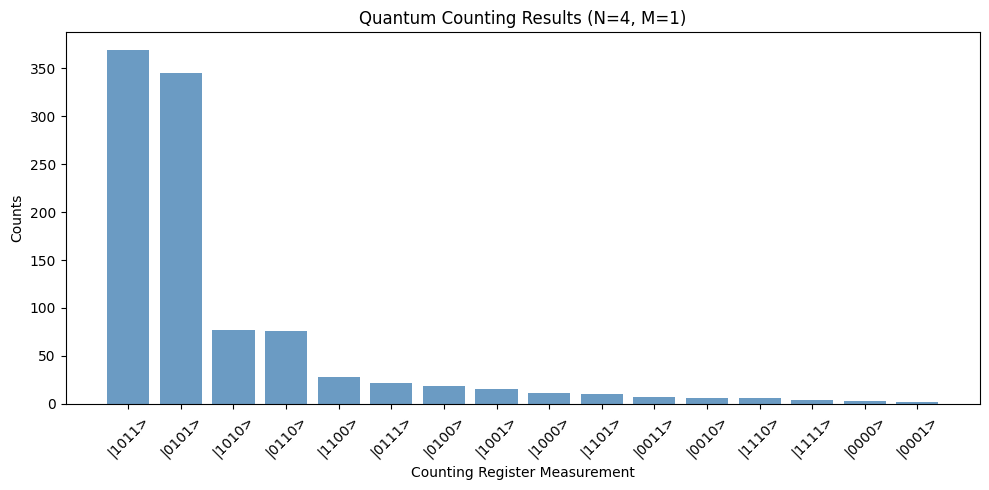

In [6]:
# Visualize counting register distribution
counting_results = results["counting_register_results"]
sorted_results = sorted(counting_results.items(), key=lambda x: x[1], reverse=True)

labels = [f"|{bs}>" for bs, _ in sorted_results]
values = [c for _, c in sorted_results]

plt.figure(figsize=(10, 5))
plt.bar(labels, values, color="steelblue", alpha=0.8)
plt.xlabel("Counting Register Measurement")
plt.ylabel("Counts")
plt.title(f"Quantum Counting Results (N={N}, M={len(marked_states)})")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Understanding the Estimate Accuracy

The estimate $M \approx 1.23$ rather than exactly $M = 1$ arises for two reasons:

1. **Not in an eigenstate:** QPE works perfectly when the input state is an eigenstate of the operator. However, the uniform superposition $|s\rangle = H^{\otimes n}|0\rangle^{\otimes n}$ that we prepare is generally **not** an eigenstate of $G$. Instead, it is a superposition of both eigenstates:

$$|s\rangle = \sin(\theta/2)|\beta\rangle + \cos(\theta/2)|\alpha\rangle$$

   where $|\alpha\rangle$ and $|\beta\rangle$ are the eigenstates of $G$ with eigenvalues $e^{+i\theta}$ and $e^{-i\theta}$ respectively. Because we start in this superposition, QPE produces **both** phase estimates $\varphi$ and $1 - \varphi$, which is why we see two dominant peaks in the histogram.

2. **Finite precision:** When the true phase $\theta/(2\pi)$ is not exactly representable as a $t$-bit fraction $y/2^t$, there is a discretization error. Using more counting qubits (larger $t$) reduces this error and gives a more precise estimate of $M$.

## Example 2: Counting Multiple Marked Items

Count 2 marked items in an 8-element search space ($N = 8$, $n = 3$).

In [7]:
n_counting = 5
n_search = 3
marked_states_2 = [2, 5]
N_2 = 2**n_search

counting_qubits_2 = list(range(n_counting))
search_qubits_2 = list(range(n_counting, n_counting + n_search))

circ_2 = Circuit()
circ_2 = quantum_counting_circuit(
    circ_2, counting_qubits_2, search_qubits_2, marked_states_2
)

device = LocalSimulator()
task_2 = device.run(circ_2, shots=2000)

print(f"Quantum Counting Results (N={N_2}, M={len(marked_states_2)}):")
results_2 = get_quantum_counting_results(
    task_2, counting_qubits_2, search_qubits_2, verbose=True
)

print(f"\nActual M = {len(marked_states_2)}")
print(f"Estimated M = {results_2['best_estimate']:.4f}")

Quantum Counting Results (N=8, M=2):
Search space size N = 8

Counting register distribution (top outcomes):
  |01011>: 687 counts  ->  phase = 0.1562,  M ~ 1.7777
  |10101>: 671 counts  ->  phase = 0.1562,  M ~ 1.7777
  |10110>: 204 counts  ->  phase = 0.1875,  M ~ 2.4693
  |01010>: 173 counts  ->  phase = 0.1875,  M ~ 2.4693
  |01100>: 51 counts  ->  phase = 0.1250,  M ~ 1.1716
  |10100>: 39 counts  ->  phase = 0.1250,  M ~ 1.1716
  ... (23 more outcomes)

Best estimate of M: 1.777719067921591

Actual M = 2
Estimated M = 1.7777


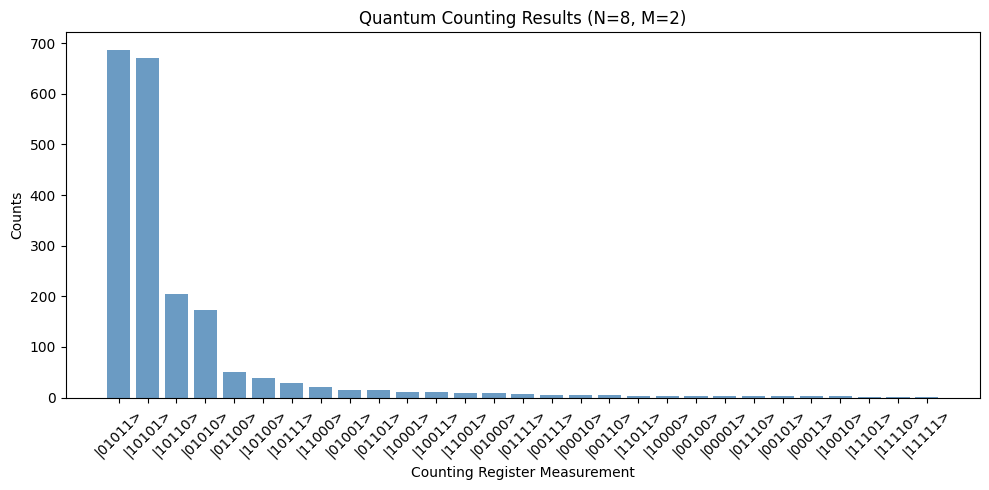

In [8]:
# Visualize Example 2 results
counting_results_2 = results_2["counting_register_results"]
sorted_results_2 = sorted(counting_results_2.items(), key=lambda x: x[1], reverse=True)

labels_2 = [f"|{bs}>" for bs, _ in sorted_results_2]
values_2 = [c for _, c in sorted_results_2]

plt.figure(figsize=(10, 5))
plt.bar(labels_2, values_2, color="steelblue", alpha=0.8)
plt.xlabel("Counting Register Measurement")
plt.ylabel("Counts")
plt.title(f"Quantum Counting Results (N={N_2}, M={len(marked_states_2)})")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Example 3: Edge Case — No Marked Items (M = 0)

When no items are marked, the algorithm should estimate $M \approx 0$.

In [9]:
n_counting = 4
n_search = 2
marked_states_3 = []
N_3 = 2**n_search

counting_qubits_3 = list(range(n_counting))
search_qubits_3 = list(range(n_counting, n_counting + n_search))

circ_3 = Circuit()
circ_3 = quantum_counting_circuit(
    circ_3, counting_qubits_3, search_qubits_3, marked_states_3
)

device = LocalSimulator()
task_3 = device.run(circ_3, shots=1000)

results_3 = get_quantum_counting_results(
    task_3, counting_qubits_3, search_qubits_3, verbose=True
)

print(f"\nActual M = 0")
print(f"Estimated M = {results_3['best_estimate']:.4f}")

Search space size N = 4

Counting register distribution (top outcomes):
  |1000>: 1000 counts  ->  phase = 0.0000,  M ~ 0.0000

Best estimate of M: 0.0

Actual M = 0
Estimated M = 0.0000


## Example 4: Edge Case — All Items Marked (M = N)

When all items are marked, $M = N$.

In [10]:
n_counting = 4
n_search = 2
N_4 = 2**n_search
marked_states_4 = list(range(N_4))

counting_qubits_4 = list(range(n_counting))
search_qubits_4 = list(range(n_counting, n_counting + n_search))

circ_4 = Circuit()
circ_4 = quantum_counting_circuit(
    circ_4, counting_qubits_4, search_qubits_4, marked_states_4
)

device = LocalSimulator()
task_4 = device.run(circ_4, shots=1000)

results_4 = get_quantum_counting_results(
    task_4, counting_qubits_4, search_qubits_4, verbose=True
)

print(f"\nActual M = {N_4}")
print(f"Estimated M = {results_4['best_estimate']:.4f}")

Search space size N = 4

Counting register distribution (top outcomes):
  |0000>: 1000 counts  ->  phase = 0.5000,  M ~ 4.0000

Best estimate of M: 4.0

Actual M = 4
Estimated M = 4.0000


## [Optional] Run on a QPU or Managed Simulator

**Note:** The current implementation uses `Circuit.unitary()` for the controlled-Grover operations within QPE. This gate-synthesis approach works on simulators but is **not directly compatible with QPU execution**, which requires circuits decomposed into native gate sets. To run on a QPU, the controlled-Grover operator would need to be fully decomposed into native one- and two-qubit gates.

[Include estimated price for running in USD using the [cost tracker](https://docs.aws.amazon.com/braket/latest/developerguide/braket-pricing.html#real-time-cost-tracking).]

In [11]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
# from braket.tracking import Tracker

# tracker = Tracker().start()

In [12]:
# from braket.aws import AwsDevice, AwsSession
# import boto3

# boto_session = boto3.Session(region_name="us-east-1")
# aws_session = AwsSession(boto_session=boto_session)

# # Run on managed simulator
# managed_device = AwsDevice(
#     "arn:aws:braket:::device/quantum-simulator/amazon/sv1",
#     aws_session=aws_session
# )
# n_counting = 4
# n_search = 2
# marked_states = [3]
# counting_qubits = list(range(n_counting))
# search_qubits = list(range(n_counting, n_counting + n_search))

# circ = Circuit()
# circ = quantum_counting_circuit(
#     circ, counting_qubits, search_qubits, marked_states
# )

# task = managed_device.run(circ, shots=1000)

# results = get_quantum_counting_results(
#     task, counting_qubits, search_qubits, verbose=True
# )
# print(f"\nEstimated M = {results['best_estimate']:.4f}")

In [13]:
# print("Task Summary")
# print(f"{tracker.quantum_tasks_statistics()} \n")
# print(
#     f"Estimated cost to run this example: {tracker.qpu_tasks_cost() + tracker.simulator_tasks_cost():.2f} USD"
# )

Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).